In [89]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 이미지 디렉토리 경로
image_dir = "/home/jovyan/bloodcell/images"

# 새로운 train, test 디렉토리 경로
train_dir = "/home/jovyan/bloodcell/train"
test_dir = "/home/jovyan/bloodcell/test"

# 이미지 파일 목록 가져오기 (디렉토리 제외)
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# 학습용, 테스트용 데이터셋 나누기 (예: 80% 학습, 20% 테스트)
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# train, test 디렉토리가 없으면 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 이미지 파일을 각각 train, test 폴더로 복사
for file in train_files:
    shutil.copy(os.path.join(image_dir, file), os.path.join(train_dir, file))

for file in test_files:
    shutil.copy(os.path.join(image_dir, file), os.path.join(test_dir, file))

print(f"총 {len(train_files)}개의 이미지가 train 폴더에, {len(test_files)}개의 이미지가 test 폴더에 복사되었습니다.")


총 80개의 이미지가 train 폴더에, 20개의 이미지가 test 폴더에 복사되었습니다.


In [90]:
import os
import json
from PIL import Image
import pandas as pd

# 경로 설정
image_dir = "/home/jovyan/bloodcell/images"
train_dir = "/home/jovyan/bloodcell/train"
test_dir = "/home/jovyan/bloodcell/test"
annotation_file = "/home/jovyan/bloodcell/annotations.csv"

# CSV 파일 읽기
annotations = pd.read_csv(annotation_file)

# COCO 형식으로 annotations.json 파일 생성
def create_coco_format_annotations(image_dir, annotation_file, output_file):
    # 카테고리 매핑 (label -> category_id)
    categories = [
        {"id": 1, "name": "rbc"},
        {"id": 2, "name": "wbc"},
        {"id": 3, "name": "background"}
    ]
    
    # 이미지 목록 생성
    images = []
    annotations_list = []
    image_id = 1
    annotation_id = 1

    # 이미지 및 annotation 정보를 COCO 형식으로 변환
    for file_name in os.listdir(image_dir):
        if file_name.endswith('.jpg') or file_name.endswith('.png'):  # 이미지 파일만 처리
            image_path = os.path.join(image_dir, file_name)
            img = Image.open(image_path)
            width, height = img.size

            # 이미지 정보 추가
            images.append({
                "id": image_id,
                "file_name": file_name,
                "width": width,
                "height": height
            })

            # 해당 이미지에 대한 annotation 정보 추가
            img_annotations = annotations[annotations['image'] == file_name]
            for _, row in img_annotations.iterrows():
                xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
                category_id = get_label_id(row['label'])

                annotations_list.append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],  # [xmin, ymin, width, height]
                    "area": (xmax - xmin) * (ymax - ymin),
                    "iscrowd": 0
                })
                annotation_id += 1

            image_id += 1

    # COCO 형식 JSON 구조 생성
    coco_format = {
        "images": images,
        "annotations": annotations_list,
        "categories": categories
    }

    # 파일로 저장
    with open(output_file, 'w') as f:
        json.dump(coco_format, f, indent=4)

    print(f"COCO 형식으로 변환된 annotations 파일이 '{output_file}'에 저장되었습니다.")

# get_label_id 함수
def get_label_id(label):
    label_map = {
        "rbc": 1,
        "wbc": 2,
        "background": 3  # background 클래스를 추가
    }
    return label_map.get(label, 0)  # 'background'가 기본 값

# train 및 test 디렉토리에 대해 각각 COCO 형식으로 annotations 생성
create_coco_format_annotations(train_dir, annotation_file, "/home/jovyan/bloodcell/train_annotations.json")
create_coco_format_annotations(test_dir, annotation_file, "/home/jovyan/bloodcell/test_annotations.json")


COCO 형식으로 변환된 annotations 파일이 '/home/jovyan/bloodcell/train_annotations.json'에 저장되었습니다.
COCO 형식으로 변환된 annotations 파일이 '/home/jovyan/bloodcell/test_annotations.json'에 저장되었습니다.


#### 본격적시작

In [91]:
import os
import torch
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset


# root : /home/jovyan/bloodcell
class CustomDataset(Dataset):
    def __init__(self,root,train,transform = None):
        super().__init__()
        directory = "train" if train else "test"
        annotations = os.path.join(root,"annotations", f"{directory}_annotations.json")

        self.coco =COCO(annotations)
        self.image_path = os.path.join(root,directory)
        self.transform = transform

        self.categories = self._get_categories()
        self.data = self._load_data()

    def _get_categories(self):
        categories = {0: "background"}
        for category in self.coco.cats.values():
            categories[category["id"]] = category["name"]
        return categories

    def _load_data(self) : 
        data = []
        for _id in self.coco.imgs:
            file_name = self.coco.loadImgs(_id)[0]["file_name"] #개별파일이름
            image_path = os.path.join(self.image_path,file_name) #개별파일 경로
            image = Image.open(image_path)#.convert("RGB") #바꿀필요있나 그레이스케일인데

            boxes = []
            labels = []
            anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
            for ann in anns : 
                x,y,w,h = ann["bbox"]
                boxes.append([x,y,x+w,y+h])
                labels.append(ann["category_id"])

            target = {
                "image_id" : torch.LongTensor([_id]),
                "boxes" : torch.FloatTensor(boxes),
                "labels" : torch.LongTensor(labels)
            }
            data.append([image,target])
        return data


    def __getitem__(self,index):
        image,target = self.data[index]
        if self.transform : 
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.data)


In [92]:
from torchvision import transforms
from torch.utils.data import DataLoader
def collator(batch):
    return tuple(zip(*batch))
    
transform = transforms.Compose(
    [
        # 이미지 열기
        transforms.Lambda(lambda x: x.convert("RGB")),  # 알파 채널을 제거하고 RGB로 변환
        transforms.PILToTensor(),  # PIL 이미지를 텐서로 변환
        transforms.ConvertImageDtype(dtype=torch.float),  # 데이터 타입을 float으로 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
    ]
)

In [93]:
train_dataset = CustomDataset('/home/jovyan/bloodcell', train = True, transform = transform)
test_dataset = CustomDataset('/home/jovyan/bloodcell', train = False, transform = transform)
train_dataloader = DataLoader( train_dataset, batch_size= 1, shuffle= True, drop_last= True, collate_fn= collator )
test_dataloader = DataLoader( test_dataset, batch_size= 1, shuffle= True, drop_last= True, collate_fn= collator )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## 모델

In [94]:
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN

backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features
backbone.out_channels = 512

anchor_generator = rpn.AnchorGenerator(
    sizes = ((32,64,128,256,512),),
    aspect_ratios = ((0.5,1.0,2.0),)
)

roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names= ["0"],
    output_size = (7,7),
    sampling_ratio =  2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FasterRCNN(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool = roi_pooler
).to(device)

#최적화 함수 및 스케줄러
from torch import optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr = 0.001, momentum= 0.9, weight_decay= 0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma = 0.1)


In [95]:
#모델학습 
epoch_num = 20
for epoch in range(epoch_num):
    cost = 0.0
    for idx, (images,targets) in enumerate(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k :v.to(device) for k , v in t.items()} for t in targets]

        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        cost+=losses

    lr_scheduler.step()
    cost = cost/len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 1.604
Epoch :    2, Cost : 1.053
Epoch :    3, Cost : 0.881
Epoch :    4, Cost : 0.759
Epoch :    5, Cost : 0.702
Epoch :    6, Cost : 0.587
Epoch :    7, Cost : 0.557
Epoch :    8, Cost : 0.547
Epoch :    9, Cost : 0.533
Epoch :   10, Cost : 0.526
Epoch :   11, Cost : 0.510
Epoch :   12, Cost : 0.505
Epoch :   13, Cost : 0.509
Epoch :   14, Cost : 0.509
Epoch :   15, Cost : 0.500
Epoch :   16, Cost : 0.511
Epoch :   17, Cost : 0.505
Epoch :   18, Cost : 0.502
Epoch :   19, Cost : 0.503
Epoch :   20, Cost : 0.505


In [96]:
# 학습 후 모델 저장
torch.save(model.state_dict(), 'bloodcell.pth')


In [97]:
##평가
import numpy as np
from pycocotools.cocoeval import COCOeval
import torch
import gc

model.eval()
custom_detections = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)):
            image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()

            # 낮은 점수 필터링
            threshold = 0.5
            keep_indices = scores > threshold
            boxes = boxes[keep_indices]
            scores = scores[keep_indices]
            labels = labels[keep_indices]

            # Bounding box 크기 변환
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            for instance_id in range(len(boxes)):
                box = boxes[instance_id, :].tolist()
                prediction = [
                    image_id,
                    box[0],
                    box[1],
                    box[2],
                    box[3],
                    float(scores[instance_id]),
                    int(labels[instance_id]),
                ]
                custom_detections.append(prediction)

        # 메모리 정리
        torch.cuda.empty_cache()
        gc.collect()

custom_detections = np.asarray(custom_detections)

# COCO API 호출
custom_gt = test_dataloader.dataset.coco
custom_dt = custom_gt.loadRes(custom_detections)
custom_evaluator = COCOeval(custom_gt, custom_dt, iouType="bbox")
custom_evaluator.evaluate()
custom_evaluator.accumulate()
custom_evaluator.summarize()


Loading and preparing results...
Converting ndarray to lists...
(526, 7)
0/526
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.694
 Average Recall     (A

In [98]:
##시각화

In [99]:
def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(
            xy = (box[0],box[1]),
            width=box[2]-box[0],
            height = box[3]-box[1],
            fill=False,
            edgecolor = color,
            linewidth = 2,)
)
    ax.annotate(
        text = text,
        xy = (box[0] -5, box[1] -5),
        color = color,
        weight = 'bold',    
        fontsize = 13
    )

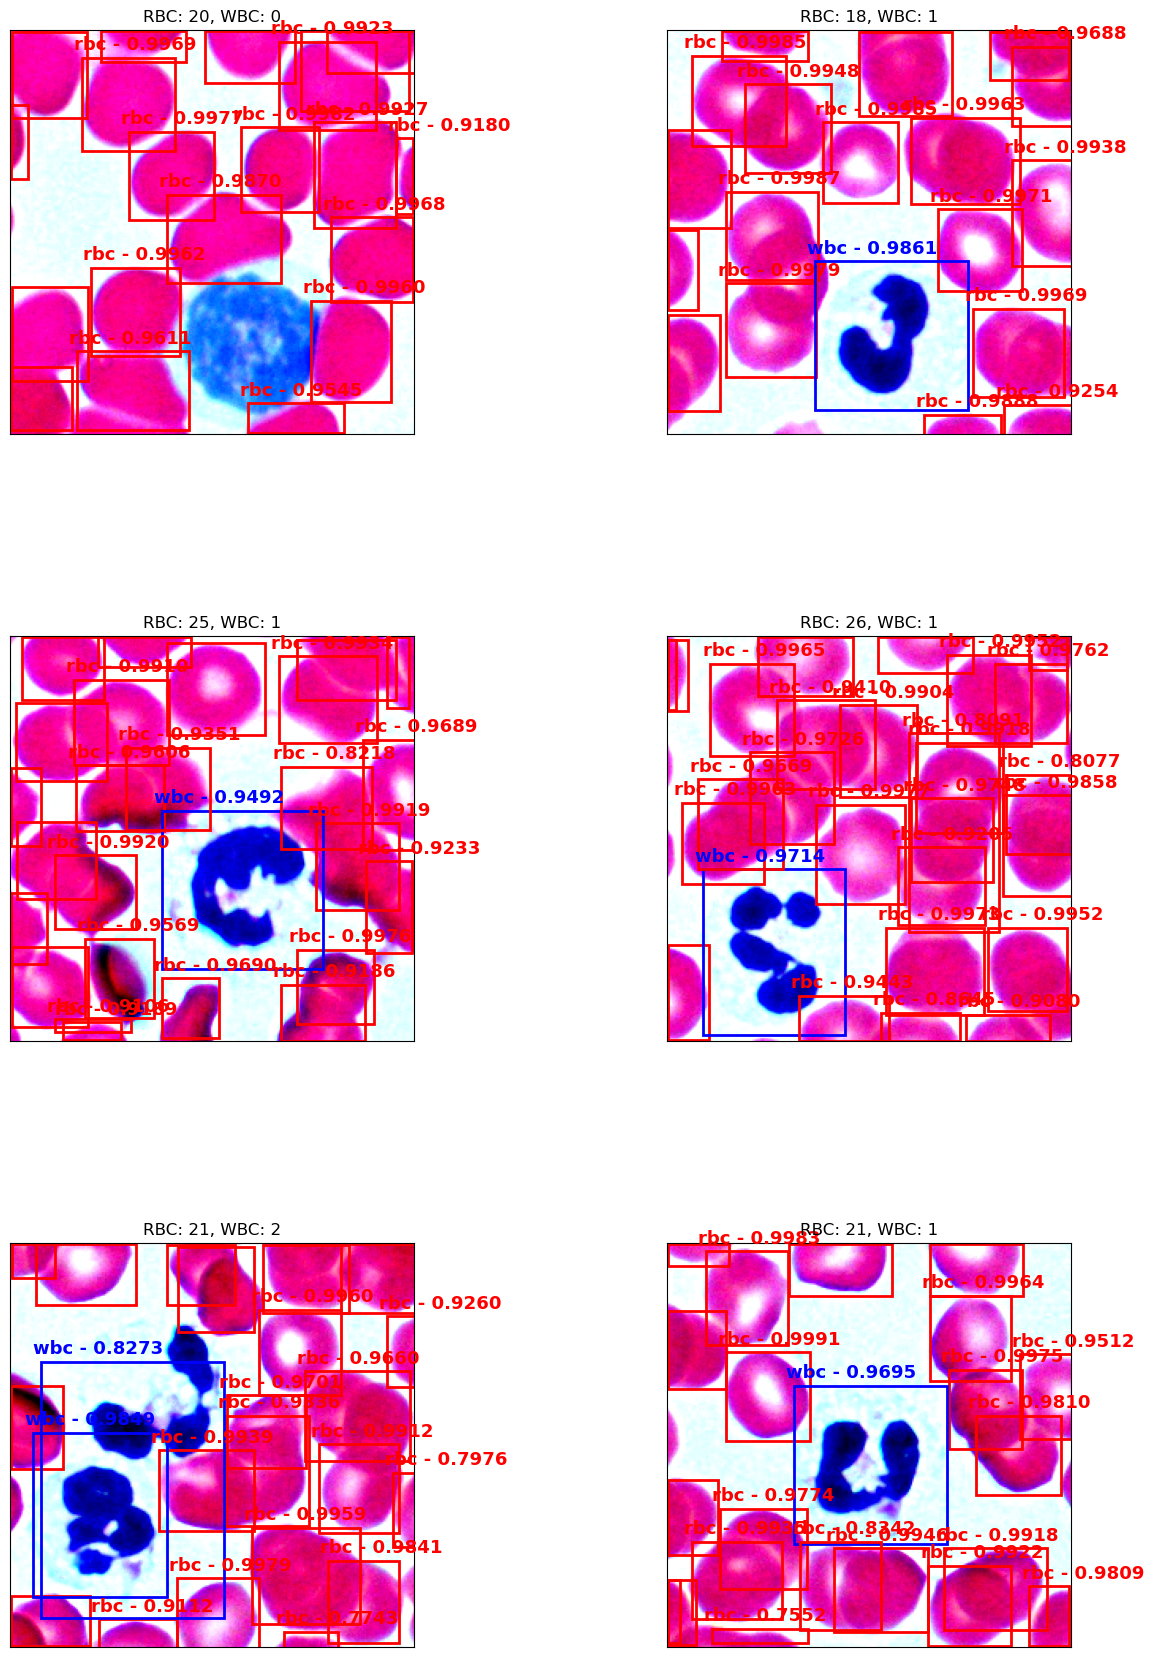

In [100]:
from torchvision.transforms.functional import to_pil_image

threshold = 0.7
categories = test_dataset.categories
num_images_to_show = 6  # 시각화할 이미지 수

# 예측된 블러드셀과 백혈구 개수를 세기 위한 변수들
blood_cell_count = 0
white_blood_cell_count = 0

# 이미지 갯수에 맞춰 행렬 형식으로 그릴 수 있도록 subplot 준비
num_cols = 2  # 한 줄에 표시할 이미지 수
num_rows = (num_images_to_show + num_cols - 1) // num_cols  # 필요한 행 계산

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 7))  # 충분한 크기의 레이아웃 설정
axes = axes.flatten()  # 2D 배열을 1D 배열로 변환하여 쉽게 접근

with torch.no_grad():
    model.eval()
    image_count = 0  # 시각화한 이미지 수 카운팅
    for images, targets in test_dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()

        # 스코어 기준으로 박스 필터링
        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        # 예측된 블러드셀과 백혈구 개수 카운트
        blood_cell_count = np.sum(labels == 1)  # 블러드셀이 라벨 1로 설정된 경우
        white_blood_cell_count = np.sum(labels == 2)  # 백혈구가 라벨 2로 설정된 경우

        # 이미지를 PIL로 변환 (이전에 텐서를 0-255 범위로 변환)
        pil_image = to_pil_image(images[0].cpu().clamp(0, 1))  # 0~1 범위로 클램프 후 PIL 이미지로 변환
        pil_image = pil_image.convert("RGB")  # RGB로 변환

        # 이미지 표시 (각각의 서브플롯에 이미지 추가)
        ax = axes[image_count]
        ax.imshow(pil_image)  # 컬러 이미지로 표시

        # 예측된 박스, 라벨, 스코어 시각화 (라벨에 따라 색상을 다르게)
        for box, label, score in zip(boxes, labels, scores):
            # 라벨 1 (블러드셀)은 빨간색, 라벨 2 (백혈구)는 파란색으로 표시
            color = "red" if label == 1 else "blue"
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", color)

        # 텍스트는 이미지 아래에 표시
        ax.set_xticks([])  # x축 눈금 없애기
        ax.set_yticks([])  # y축 눈금 없애기
        ax.set_title(f"RBC: {blood_cell_count}, WBC: {white_blood_cell_count}", fontsize=12)

        image_count += 1
        if image_count >= num_images_to_show:
            break  # 설정한 수만큼 이미지를 출력한 후 종료

    # 남은 빈 subplot에 빈 공간을 채우기 위해 axis 비활성화
    for i in range(image_count, len(axes)):
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # 이미지 간 간격을 조정 (세로와 가로 간격 조정)
    plt.show()
